In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [3]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'AntanishynaNV_predictions.csv'

In [4]:
def obj_to_bool (columns, df):
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

In [5]:
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()

In [6]:
def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

In [7]:
def replace_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))

In [8]:
def fill_life_square(df, coeff):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coeff

In [9]:
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [10]:
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')

In [11]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

Id  DistrictId  Rooms      Square  LifeSquare  KitchenSquare  Floor  \
0  11809          27    3.0  115.027311         NaN           10.0      4   
1   3013          22    1.0   39.832524   23.169223            8.0      7   
2   8215           1    3.0   78.342215   47.671972           10.0      2   
3   2352           1    1.0   40.409907         NaN            1.0     10   
4  13866          94    2.0   64.285067   38.562517            9.0     16   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0        10.0       2014   0.075424         B         B        11      3097   
1         8.0       1966   0.118537         B         B        30      6207   
2        17.0       1988   0.025609         B         B        33      5261   
3        22.0       1977   0.007122         B         B         1       264   
4        16.0       1972   0.282798         B         B        33      8667   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         0           NaN            0        0       B  305018.871089  
1         1        1183.0            1        0       B  177734.553407  
2         0         240.0            3        1       B  282078.720850  
3         0           NaN            0        1       B  168106.007630  
4         2           NaN            0        6       B  343995.102962

In [12]:
df_test = pd.read_csv(TEST_DATASET_PATH)

Описание датасета

    Id - идентификационный номер квартиры
    DistrictId - идентификационный номер района
    Rooms - количество комнат
    Square - площадь
    LifeSquare - жилая площадь
    KitchenSquare - площадь кухни
    Floor - этаж
    HouseFloor - количество этажей в доме
    HouseYear - год постройки дома
    Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
    Social_1, Social_2, Social_3 - социальные показатели местности
    Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
    Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
    Price - цена квартиры

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Датасет содержит три категориальных признака (Ecology_2, Ecology_3, Shops_2). По двум признакам есть пропущенные значения (LifeSquare, Healthcare_1).

Сперва избавимся от категориальных признаков.

In [14]:
obj_features = df.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

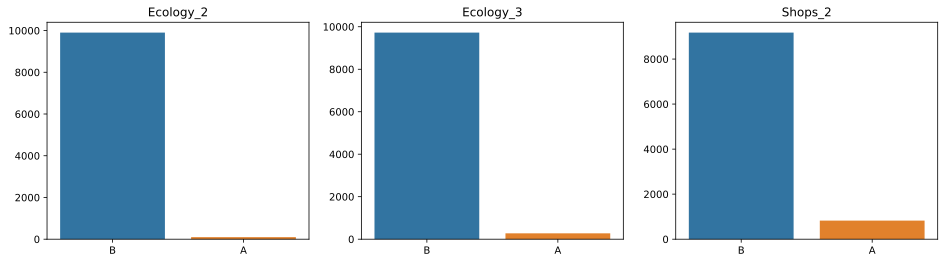

In [15]:
plt.figure(figsize = (16,4))

for i, colname in enumerate(obj_features):
    counts = df[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

In [16]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



Так как признаки принимают всего два значения, заменим их на бинарные признаки.

In [17]:
obj_to_bool(obj_features, df)

In [18]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

False    9903
True       97
Name: Ecology_2, dtype: int64

False    9725
True      275
Name: Ecology_3, dtype: int64

False    9175
True      825
Name: Shops_2, dtype: int64



Количество значений не изменилось, значит преобразование сделано правильно.

Признак Healthcare_1 содержит очень много пропущенных значений. Не будем учитывать этот признак в процессе анализа.

In [19]:
df.drop(['Healthcare_1'], axis=1, inplace=True)

Исследуем значения признаков LifeSquare и Square. Попробуем установить зависимость между жилой площадью и полной площадью квартиры.

In [20]:
df['LifeSquare'].describe()

count    7887.000000
mean       37.199645
std        86.241209
min         0.370619
25%        22.769832
50%        32.781260
75%        45.128803
max      7480.592129
Name: LifeSquare, dtype: float64

In [21]:
df['Square'].describe()

count    10000.000000
mean        56.315775
std         21.058732
min          1.136859
25%         41.774881
50%         52.513310
75%         65.900625
max        641.065193
Name: Square, dtype: float64

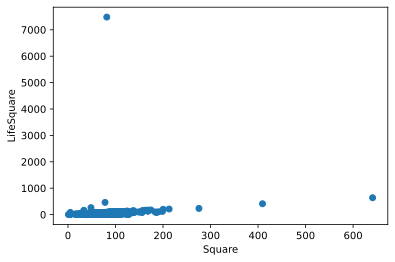

In [22]:
draw_scatter('Square', 'LifeSquare', df)

Оба признака имеют выбросы. Избавимся от них.

In [23]:
drop_by_IQ('Square', df)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.


In [24]:
drop_by_IQ('LifeSquare', df)

For column LifeSquare
	IQ:	21.75692564475336
	LOW:	-9.940131635100535
	HIGH:	77.08757094391291

Lost 1.91% of data.


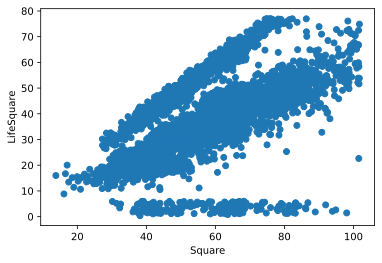

In [25]:
draw_scatter('Square', 'LifeSquare', df)

Найдём долю жилой площади от общей по сроедним значениям в выборке и заполним пропущенные значения в столбце LifeSquare.

In [26]:
square_mean_values = df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]
square_coeff

0.6378520569631778

In [27]:
fill_life_square(df, square_coeff)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9572 entries, 1 to 9999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             9572 non-null   int64  
 1   DistrictId     9572 non-null   int64  
 2   Rooms          9572 non-null   float64
 3   Square         9572 non-null   float64
 4   LifeSquare     9572 non-null   float64
 5   KitchenSquare  9572 non-null   float64
 6   Floor          9572 non-null   int64  
 7   HouseFloor     9572 non-null   float64
 8   HouseYear      9572 non-null   int64  
 9   Ecology_1      9572 non-null   float64
 10  Ecology_2      9572 non-null   bool   
 11  Ecology_3      9572 non-null   bool   
 12  Social_1       9572 non-null   int64  
 13  Social_2       9572 non-null   int64  
 14  Social_3       9572 non-null   int64  
 15  Helthcare_2    9572 non-null   int64  
 16  Shops_1        9572 non-null   int64  
 17  Shops_2        9572 non-null   bool   
 18  Price   

In [29]:
df.describe()

Id   DistrictId        Rooms       Square   LifeSquare  \
count   9572.000000  9572.000000  9572.000000  9572.000000  9572.000000   
mean    8382.207376    50.579816     1.845905    54.118859    34.519826   
std     4856.596405    43.768356     0.809624    15.594497    13.030713   
min        2.000000     0.000000     0.000000    13.784865     0.370619   
25%     4169.500000    19.000000     1.000000    41.537091    24.065821   
50%     8390.500000    36.000000     2.000000    51.217517    32.871722   
75%    12591.250000    77.000000     2.000000    64.293638    43.319537   
max    16798.000000   209.000000    19.000000   102.032801    77.052978   

       KitchenSquare        Floor   HouseFloor     HouseYear    Ecology_1  \
count    9572.000000  9572.000000  9572.000000  9.572000e+03  9572.000000   
mean        6.243105     8.471061    12.586293  4.079251e+03     0.119942   
std        29.065509     5.168552     6.628252  2.049338e+05     0.119592   
min         0.000000     1.000000     0.000000  1.910000e+03     0.000000   
25%         1.000000     4.000000     9.000000  1.973000e+03     0.017647   
50%         6.000000     7.000000    12.000000  1.977000e+03     0.075779   
75%         9.000000    12.000000    17.000000  1.999000e+03     0.195781   
max      2014.000000    42.000000   117.000000  2.005201e+07     0.521867   

          Social_1      Social_2     Social_3  Helthcare_2      Shops_1  \
count  9572.000000   9572.000000  9572.000000  9572.000000  9572.000000   
mean     24.914333   5390.685959     8.029461     1.327518     4.237986   
std      17.488685   3994.347092    23.702448     1.485634     4.792616   
min       0.000000    168.000000     0.000000     0.000000     0.000000   
25%       6.000000   1564.000000     0.000000     0.000000     1.000000   
50%      25.000000   5285.000000     2.000000     1.000000     3.000000   
75%      36.000000   7287.000000     5.000000     2.000000     6.000000   
max      74.000000  19083.000000   141.000000     6.000000    23.000000   

               Price  
count    9572.000000  
mean   209182.371820  
std     87271.970772  
min     59174.778028  
25%    151904.418474  
50%    189610.138453  
75%    244221.524382  
max    633233.466570

Признак KitchenSquare содержит выбросы. Избавимся от них.

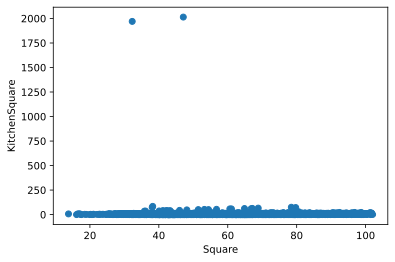

In [30]:
draw_scatter('Square', 'KitchenSquare', df)

In [31]:
replace_by_IQ('KitchenSquare', df)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.2431048892603425
In 31 row KitchenSquare was replaced to 6.2431048892603425.


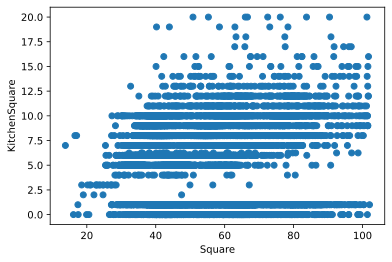

In [32]:
draw_scatter('Square', 'KitchenSquare', df)

Признак HouseYear так же содержит выпадающие значения. Обработаем их.

In [33]:
mean_year = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1984.0

In [34]:
clean_year(df, mean_year)

In [35]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

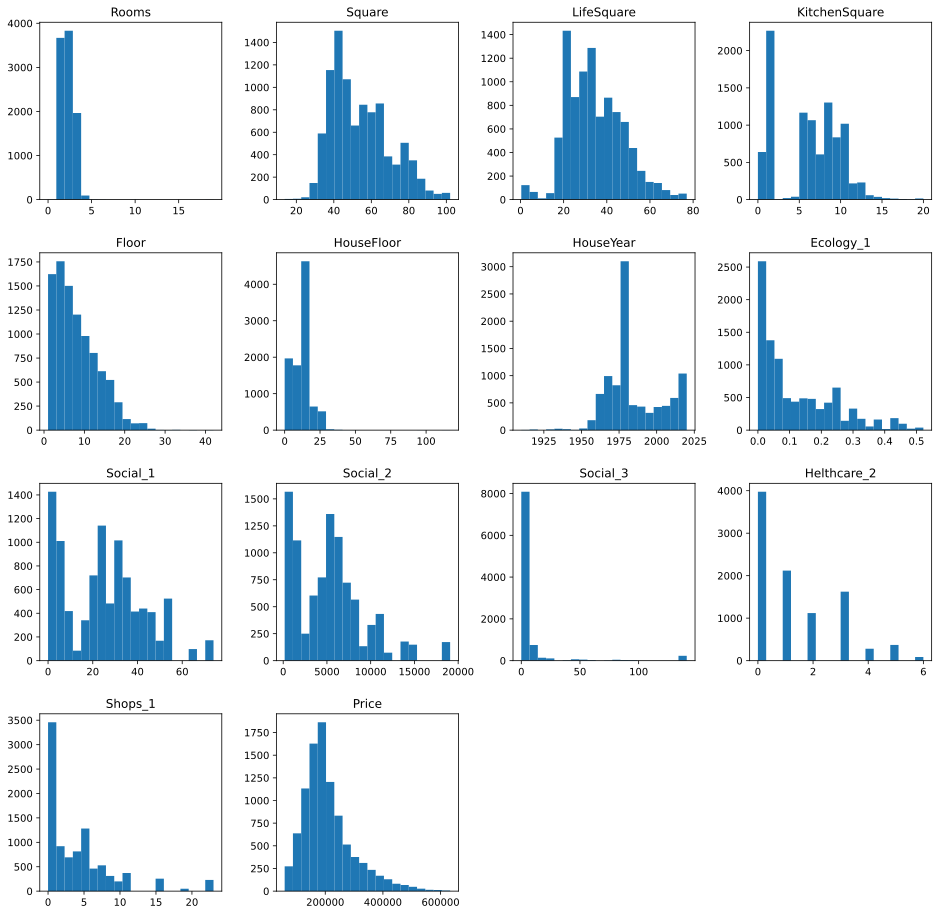

In [36]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

Сделаем то же самое для тестового датафрейма. Однако, вместо исключения выбросов по признакам Square и LifeSquare заменим выбросы на средние значения.

In [37]:
test = pd.read_csv(TEST_DATASET_PATH)
obj_to_bool(obj_features, test)
test.drop(['Healthcare_1'], axis=1, inplace=True)
replace_by_IQ('Square', test)
replace_by_IQ('LifeSquare', test)
fill_life_square(test, square_coeff)
replace_by_IQ('KitchenSquare', test)

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048
	MEAN:	56.449500363812376
In 110 row Square was replaced to 56.449500363812376.
For column LifeSquare
	IQ:	22.08206520577846
	LOW:	-10.031071759483911
	HIGH:	78.29718906362993
	MEAN:	36.15881045508669
In 118 row LifeSquare was replaced to 36.15881045508669.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.9768
In 19 row KitchenSquare was replaced to 5.9768.


Разобьем тестовый датасет на тестовый и валидационный.

In [38]:
features = df.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'

In [39]:
X = pd.DataFrame(df, columns=features)
y = pd.DataFrame(df, columns=[target])

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
X_test = test[features]
X_test.head()

Rooms     Square  LifeSquare  KitchenSquare  Floor  HouseFloor  HouseYear  \
0    1.0  36.847630   19.094182            5.0      5         9.0       1970   
1    1.0  42.493907   42.568133           10.0      7        17.0       2017   
2    2.0  59.463678   37.929030            9.0     19        19.0       1977   
3    3.0  49.646030   33.893825            6.0      2         2.0       1965   
4    1.0  53.837056   34.340077            1.0      8        17.0       1977   

   Ecology_1  Ecology_2  Ecology_3  Social_1  Social_2  Social_3  Helthcare_2  \
0   0.036122      False      False        24      4378         0            1   
1   0.072158      False      False         2       629         1            0   
2   0.211401      False      False         9      1892         0            0   
3   0.014073      False      False         2       475         0            0   
4   0.309479      False      False        35      7715         4            0   

   Shops_1  Shops_2  
0        1    False  
1        0     True  
2        1    False  
3        0    False  
4        6    False

Масштабируем данные.

In [42]:
scaler = StandardScaler()

In [43]:
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

На тренировочном наборе модели LinearRegression, Lasso и Ridge дали примерно одинаковый результат r2+score = 0.5. Наилучший результат был получен на модели RandomForestRegressor с параметрами n_estimators=1000, max_depth=9, max_features=7, random_state=42.


In [44]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

r2_train = 0.8131741919546378, mae_train: 24703.003763927663
r2_test = 0.6973115920470221, mae_test: 29230.99627966647


Предсказываем цены для тестового датасета и выгружаем результат в файл.

In [45]:
price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test['Id'], 'Price': price }).to_csv(TEST_DATASET_EXT_PATH, index=False)